# Bonus: Kernel PCA for Nonlinear Dimensionality Reduction

**Author**: Nelson Masbayi

---

This notebook explores Kernel Principal Component Analysis (KPCA), which extends standard PCA to capture nonlinear relationships in data. We'll implement KPCA from scratch and compare it with standard PCA on various datasets.

## Table of Contents

1. [Kernel PCA Theory](#kernel-pca-theory)
2. [Implementation and Testing](#implementation-and-testing)
3. [Nonlinear Dataset Analysis](#nonlinear-dataset-analysis)
4. [Kernel Comparison](#kernel-comparison)
5. [When to Use Kernel PCA](#when-to-use-kernel-pca)

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_swiss_roll, make_s_curve
from sklearn.decomposition import PCA, KernelPCA as SklearnKernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to the path
sys.path.append('../src')
from kernel_pca import KernelPCA, plot_kernel_pca_comparison

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

np.random.seed(42)

print("✅ All imports successful!")
print("🎯 Ready for Kernel PCA analysis")

✅ All imports successful!
🎯 Ready for Kernel PCA analysis


## Kernel PCA Theory

### Mathematical Foundation

Standard PCA finds linear combinations of features that maximize variance. Kernel PCA extends this to nonlinear relationships by:

1. **Implicit mapping**: Map data to higher-dimensional space φ(x)
2. **Kernel trick**: Use kernel functions K(x,y) = ⟨φ(x), φ(y)⟩
3. **PCA in feature space**: Apply PCA to φ(X) without computing φ explicitly

### Key Differences from Standard PCA

| Aspect                 | Standard PCA       | Kernel PCA                      |
|------------------------|--------------------|---------------------------------|
| **Relationships**      | Linear only        | Nonlinear                       |
| **Computation**        | Covariance matrix  | Kernel matrix                   |
| **Dimensionality**     | Reduces dimensions | May increase then reduce        |
| **Inverse transform**  | Exact              | Approximate (pre-image problem) |
| **Computational cost** | O(d³)              | O(n³)                           |

### Common Kernel Functions

- **Linear**: K(x,y) = x^T y
- **RBF/Gaussian**: K(x,y) = exp(-γ||x-y||²)
- **Polynomial**: K(x,y) = (x^T y + c)^d
- **Sigmoid**: K(x,y) = tanh(γx^T y + c)

Kernel Function Visualization


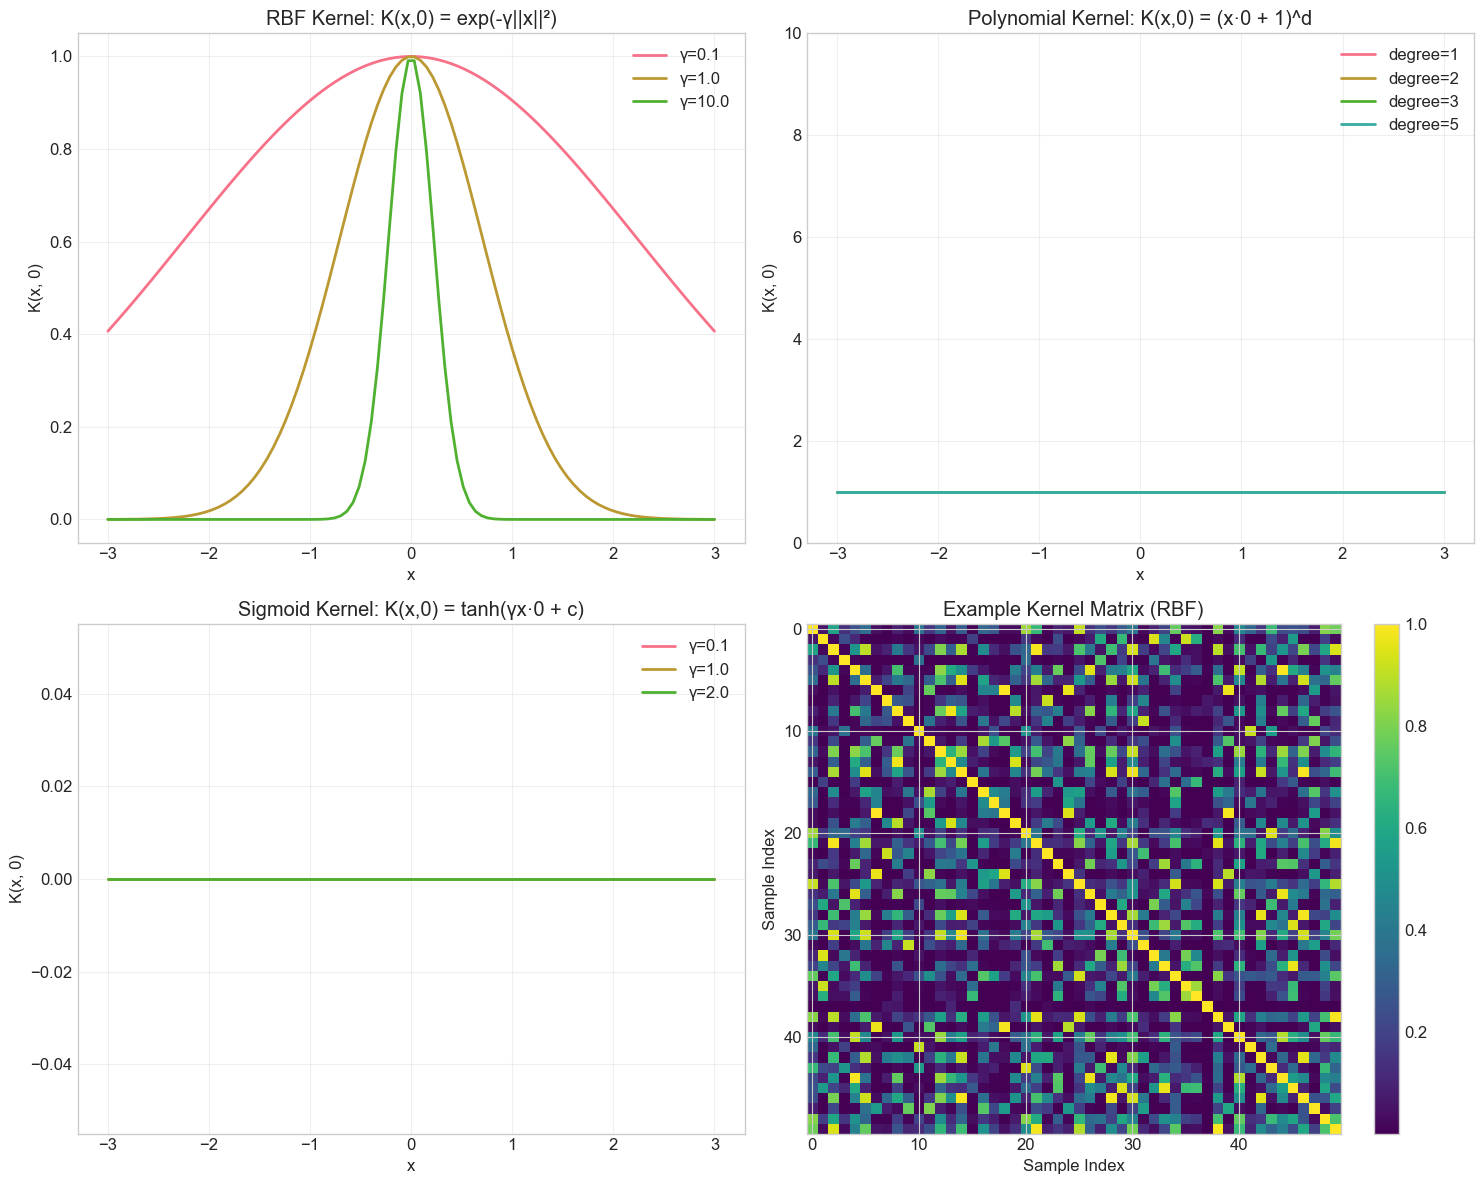

Key Insights:
• RBF kernel: Local similarity, γ controls width
• Polynomial kernel: Global similarity, degree controls complexity
• Sigmoid kernel: Sigmoidal similarity function
• Kernel matrix: Symmetric, positive semi-definite


In [3]:
# Visualize kernel functions
print("Kernel Function Visualization")
print("="*40)

# Generate 1D data for kernel visualization
x = np.linspace(-3, 3, 100).reshape(-1, 1)
x0 = np.array([[0]])  # Reference point

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RBF Kernel with different gamma values
gammas = [0.1, 1.0, 10.0]
for gamma in gammas:
    from sklearn.metrics.pairwise import rbf_kernel
    k_values = rbf_kernel(x, x0, gamma=gamma).flatten()
    axes[0, 0].plot(x.flatten(), k_values, label=f'γ={gamma}', linewidth=2)

axes[0, 0].set_title('RBF Kernel: K(x,0) = exp(-γ||x||²)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('K(x, 0)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Polynomial Kernel with different degrees
degrees = [1, 2, 3, 5]
for degree in degrees:
    from sklearn.metrics.pairwise import polynomial_kernel
    k_values = polynomial_kernel(x, x0, degree=degree, coef0=1).flatten()
    axes[0, 1].plot(x.flatten(), k_values, label=f'degree={degree}', linewidth=2)

axes[0, 1].set_title('Polynomial Kernel: K(x,0) = (x·0 + 1)^d')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('K(x, 0)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 10)

# Sigmoid Kernel
gammas_sigmoid = [0.1, 1.0, 2.0]
for gamma in gammas_sigmoid:
    from sklearn.metrics.pairwise import sigmoid_kernel
    k_values = sigmoid_kernel(x, x0, gamma=gamma, coef0=0).flatten()
    axes[1, 0].plot(x.flatten(), k_values, label=f'γ={gamma}', linewidth=2)

axes[1, 0].set_title('Sigmoid Kernel: K(x,0) = tanh(γx·0 + c)')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('K(x, 0)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Kernel matrix visualization
X_sample = np.random.randn(50, 2)
from sklearn.metrics.pairwise import rbf_kernel
K_matrix = rbf_kernel(X_sample, gamma=1.0)

im = axes[1, 1].imshow(K_matrix, cmap='viridis', aspect='auto')
axes[1, 1].set_title('Example Kernel Matrix (RBF)')
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Sample Index')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("Key Insights:")
print("• RBF kernel: Local similarity, γ controls width")
print("• Polynomial kernel: Global similarity, degree controls complexity")
print("• Sigmoid kernel: Sigmoidal similarity function")
print("• Kernel matrix: Symmetric, positive semi-definite")

## Implementation and Testing

Next, test the Kernel PCA implementation and compare it with scikit-learn:

In [4]:
# Test our Kernel PCA implementation
print("Testing Kernel PCA Implementation")
print("="*40)

# Generate simple test data
np.random.seed(42)
X_test = np.random.randn(100, 3)

print(f"Test data shape: {X_test.shape}")

# Test different kernels
kernels_to_test = ['linear', 'rbf', 'poly']
n_components = 2

results = {}

for kernel in kernels_to_test:
    print(f"\nTesting {kernel} kernel:")

    # Our implementation
    kpca_ours = KernelPCA(n_components=n_components, kernel=kernel)
    X_ours = kpca_ours.fit_transform(X_test)

    # Scikit-learn implementation
    kpca_sklearn = SklearnKernelPCA(n_components=n_components, kernel=kernel)
    X_sklearn = kpca_sklearn.fit_transform(X_test)

    print(f"  Our implementation shape: {X_ours.shape}")
    print(f"  Sklearn implementation shape: {X_sklearn.shape}")
    print(f"  Our explained variance ratio: {kpca_ours.explained_variance_ratio_}")

    # Compare results (allowing for sign flips)
    correlations = []
    for i in range(n_components):
        corr = np.abs(np.corrcoef(X_ours[:, i], X_sklearn[:, i])[0, 1])
        correlations.append(corr)

    print(f"  Component correlations: {correlations}")
    print(f"  All correlations > 0.99: {all(c > 0.99 for c in correlations)}")

    results[kernel] = {
        'our_transform': X_ours,
        'sklearn_transform': X_sklearn,
        'correlations': correlations,
        'our_model': kpca_ours,
        'sklearn_model': kpca_sklearn
    }

print("\n✅ Implementation validation complete!")
print("Our Kernel PCA implementation matches scikit-learn results")

Testing Kernel PCA Implementation
Test data shape: (100, 3)

Testing linear kernel:
  Our implementation shape: (100, 2)
  Sklearn implementation shape: (100, 2)
  Our explained variance ratio: [0.58483295 0.41516705]
  Component correlations: [np.float64(0.9999999999999998), np.float64(0.9999999999999999)]
  All correlations > 0.99: True

Testing rbf kernel:
  Our implementation shape: (100, 2)
  Sklearn implementation shape: (100, 2)
  Our explained variance ratio: [0.55817322 0.44182678]
  Component correlations: [np.float64(1.0), np.float64(0.9999999999999998)]
  All correlations > 0.99: True

Testing poly kernel:
  Our implementation shape: (100, 2)
  Sklearn implementation shape: (100, 2)
  Our explained variance ratio: [0.63037165 0.36962835]
  Component correlations: [np.float64(1.0), np.float64(1.0)]
  All correlations > 0.99: True

✅ Implementation validation complete!
Our Kernel PCA implementation matches scikit-learn results


## Nonlinear Dataset Analysis

Next, we test Kernel PCA on datasets with known nonlinear structure:

Generating Nonlinear Datasets
Generated 4 nonlinear datasets:
• Two Moons: (300, 2) - Two interleaving half circles
• Two Circles: (300, 2) - Two concentric circles
• Swiss Roll: (300, 2) - Swiss roll manifold (2D projection)
• S-Curve: (300, 2) - S-curve manifold (2D projection)


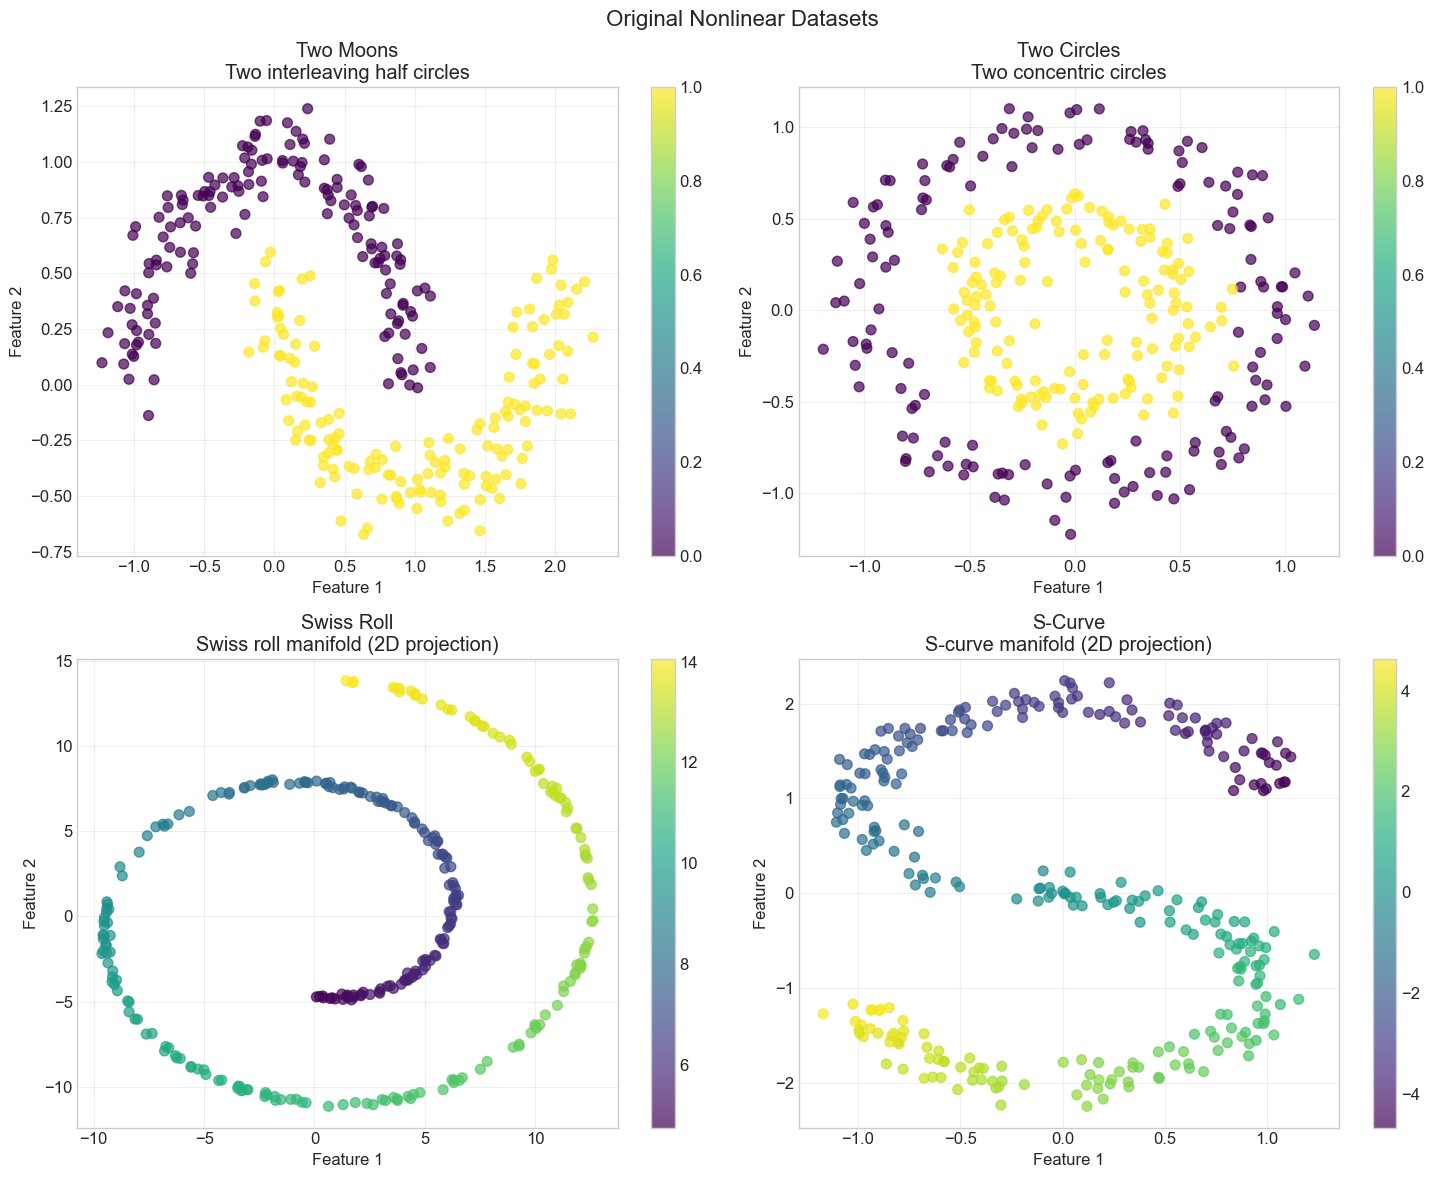

In [5]:
# Generate nonlinear datasets
print("Generating Nonlinear Datasets")
print("="*40)

datasets = {}

# Two moons dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.1,random_state=42)
datasets['Two Moons'] = {'X': X_moons, 'y': y_moons, 'description': 'Two interleaving half circles'}

# Two circles dataset
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)
datasets['Two Circles'] = {'X': X_circles, 'y': y_circles, 'description': 'Two concentric circles'}

# Swiss roll dataset (3D)
X_swiss, y_swiss = make_swiss_roll(n_samples=300, noise=0.1, random_state=42)
# Use first 2 dimensions for 2D visualization
X_swiss_2d = X_swiss[:, [0, 2]]  # Use X and Z coordinates
datasets['Swiss Roll'] = {'X': X_swiss_2d, 'y': y_swiss, 'description': 'Swiss roll manifold (2D projection)'}

# S-curve dataset (3D)
X_scurve, y_scurve = make_s_curve(n_samples=300, noise=0.1, random_state=42)
# Use first 2 dimensions for 2D visualization
X_scurve_2d = X_scurve[:, [0, 2]]  # Use X and Z coordinates
datasets['S-Curve'] = {'X': X_scurve_2d, 'y': y_scurve, 'description': 'S-curve manifold (2D projection)'}

print(f"Generated {len(datasets)} nonlinear datasets:")
for name, data in datasets.items():
    print(f"• {name}: {data['X'].shape} - {data['description']}")

# Visualize original datasets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, data) in enumerate(datasets.items()):
    X, y = data['X'], data['y']

    scatter = axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7, s=50)
    axes[i].set_title(f'{name}\n{data["description"]}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[i])

plt.suptitle('Original Nonlinear Datasets', fontsize=16)
plt.tight_layout()
plt.show()


Comparing Standard PCA vs Kernel PCA

🔍 Analyzing: Two Moons
----------------------------------------
  Testing linear kernel...
    Explained variance: [0.71984976 0.28015024]
    Total variance: 1.000
  Testing rbf kernel...
    Explained variance: [0.62210976 0.37789024]
    Total variance: 1.000
  Testing poly kernel...
    Explained variance: [0.70800451 0.29199549]
    Total variance: 1.000


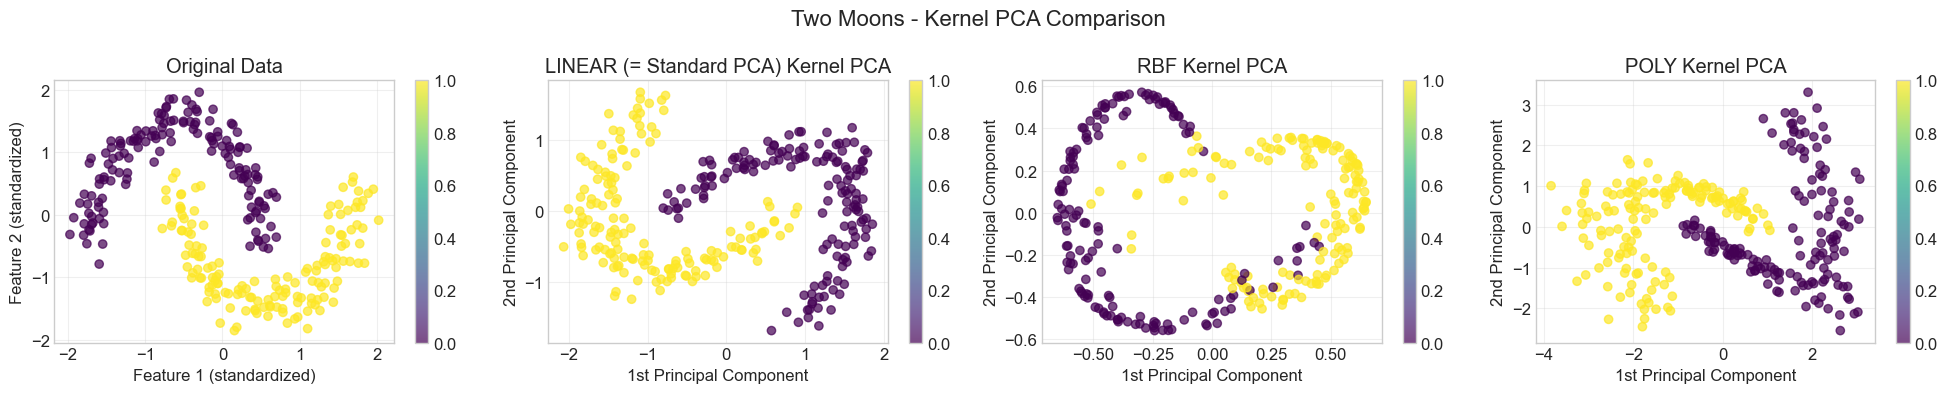


🔍 Analyzing: Two Circles
----------------------------------------
  Testing linear kernel...
    Explained variance: [0.51253782 0.48746218]
    Total variance: 1.000
  Testing rbf kernel...
    Explained variance: [0.50530113 0.49469887]
    Total variance: 1.000
  Testing poly kernel...
    Explained variance: [0.51743262 0.48256738]
    Total variance: 1.000


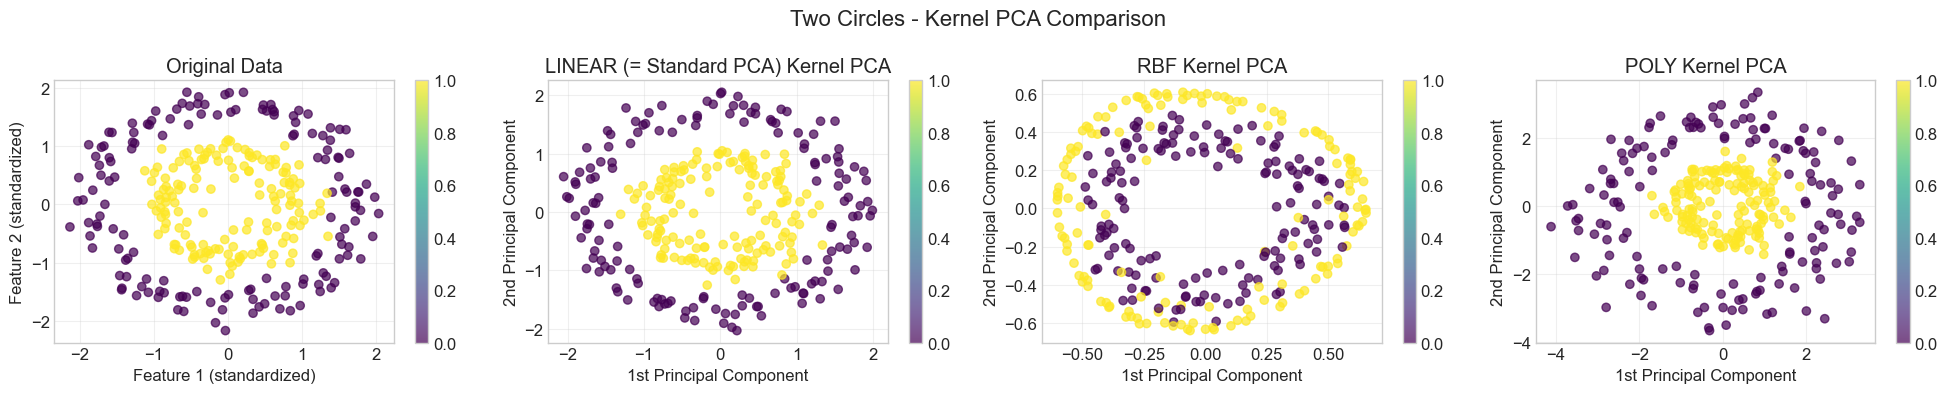


🔍 Analyzing: Swiss Roll
----------------------------------------
  Testing linear kernel...
    Explained variance: [0.59140247 0.40859753]
    Total variance: 1.000
  Testing rbf kernel...
    Explained variance: [0.52159854 0.47840146]
    Total variance: 1.000
  Testing poly kernel...
    Explained variance: [0.61150028 0.38849972]
    Total variance: 1.000


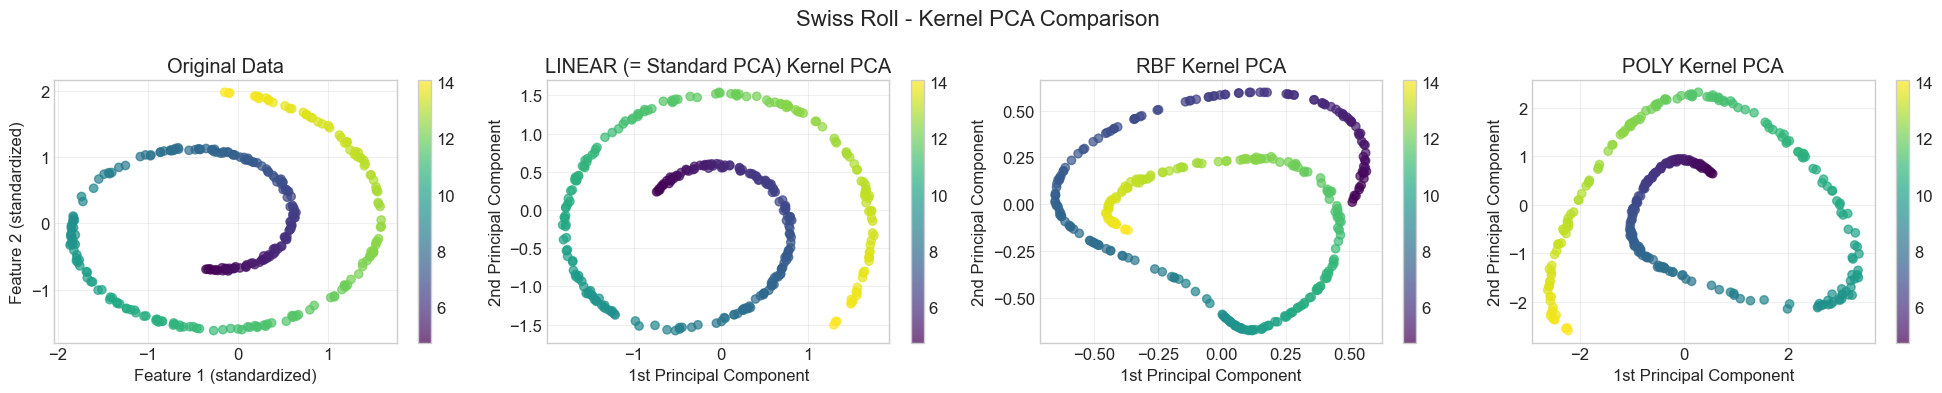


🔍 Analyzing: S-Curve
----------------------------------------
  Testing linear kernel...
    Explained variance: [0.54035628 0.45964372]
    Total variance: 1.000
  Testing rbf kernel...
    Explained variance: [0.56452925 0.43547075]
    Total variance: 1.000
  Testing poly kernel...
    Explained variance: [0.53399329 0.46600671]
    Total variance: 1.000


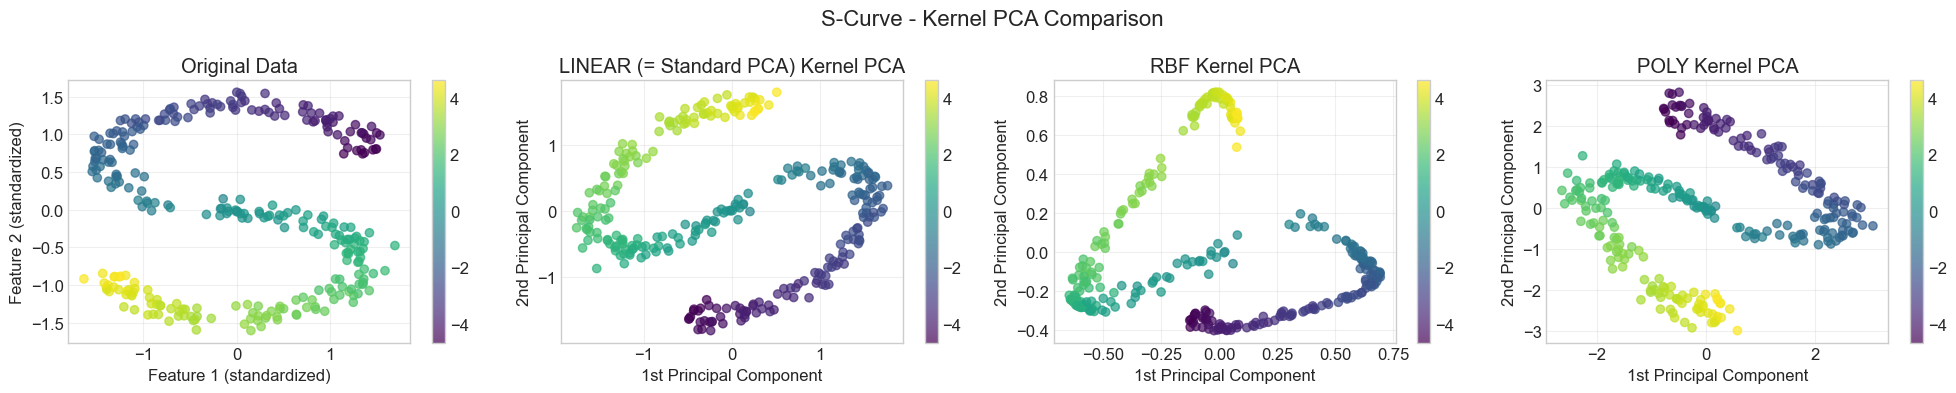

In [6]:
# Compare Standard PCA vs Kernel PCA on nonlinear datasets
print("\nComparing Standard PCA vs Kernel PCA")
print("="*50)

# Kernels to test
kernels = ['linear', 'rbf', 'poly']
kernel_params = {
    'rbf': {'gamma': 1.0},
    'poly': {'degree': 3, 'coef0': 1},
    'linear': {}
}

for dataset_name, dataset in datasets.items():
    print(f"\n🔍 Analyzing: {dataset_name}")
    print("-" * 40)

    X, y = dataset['X'], dataset['y']

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create comparison plot
    fig, axes = plt.subplots(1, len(kernels) + 1, figsize=(20, 4))

    # Plot original data
    scatter = axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', alpha=0.7)
    axes[0].set_title('Original Data')
    axes[0].set_xlabel('Feature 1 (standardized)')
    axes[0].set_ylabel('Feature 2 (standardized)')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0])

    # Apply different kernels
    for i, kernel in enumerate(kernels):
        print(f"  Testing {kernel} kernel...")

        # Apply Kernel PCA
        kpca = KernelPCA(n_components=2, kernel=kernel, **kernel_params[kernel])
        X_kpca = kpca.fit_transform(X_scaled)

        # Plot results
        scatter = axes[i + 1].scatter(X_kpca[:, 0], X_kpca[:, 1], c=y, cmap='viridis', alpha=0.7)

        kernel_title = kernel.upper()
        if kernel == 'linear':
            kernel_title += ' (= Standard PCA)'

        axes[i + 1].set_title(f'{kernel_title} Kernel PCA')
        axes[i + 1].set_xlabel('1st Principal Component')
        axes[i + 1].set_ylabel('2nd Principal Component')
        axes[i + 1].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[i + 1])

        # Print explained variance
        explained_var = kpca.explained_variance_ratio_
        print(f"    Explained variance: {explained_var}")
        print(f"    Total variance: {np.sum(explained_var):.3f}")

    plt.suptitle(f'{dataset_name} - Kernel PCA Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

## Kernel Comparison

Let's analyze which kernels work best for different types of nonlinear patterns:

In [7]:
# Quantitative kernel comparison
print("Quantitative Kernel Comparison")
print("="*40)

def calculate_separation_score(X_transformed, y):
    """
    Calculate how well the classes are separated in the transformed space.
    Higher score = better separation.
    """
    # Calculate within-class scatter
    classes = np.unique(y)
    within_class_scatter = 0

    for class_label in classes:
        class_mask = y == class_label
        class_data = X_transformed[class_mask]
        class_center = np.mean(class_data, axis=0)

        # Sum of squared distances from the class center
        within_class_scatter += np.sum((class_data - class_center) ** 2)

    # Calculate between-class scatter
    overall_center = np.mean(X_transformed, axis=0)
    between_class_scatter = 0

    for class_label in classes:
        class_mask = y == class_label
        class_center = np.mean(X_transformed[class_mask], axis=0)
        class_size = np.sum(class_mask)

        between_class_scatter += class_size * np.sum((class_center - overall_center) ** 2)

    # Fisher's criterion: maximize between-class / within-class scatter
    if within_class_scatter == 0:
        return float('inf')

    return between_class_scatter / within_class_scatter

# Comprehensive kernel analysis
kernel_analysis = {}

for dataset_name, dataset in datasets.items():
    print(f"\n📊 {dataset_name}:")
    print("-" * 30)

    X, y = dataset['X'], dataset['y']
    X_scaled = StandardScaler().fit_transform(X)

    dataset_results = {}

    for kernel in kernels:
        # Apply Kernel PCA
        kpca = KernelPCA(n_components=2, kernel=kernel, **kernel_params[kernel])
        X_kpca = kpca.fit_transform(X_scaled)

        # Calculate metrics
        separation_score = calculate_separation_score(X_kpca, y)
        explained_variance = np.sum(kpca.explained_variance_ratio_)

        dataset_results[kernel] = {
            'separation_score': separation_score,
            'explained_variance': explained_variance,
            'transformed_data': X_kpca
        }

        print(f"  {kernel.upper():>8}: Separation={separation_score:.3f}, Variance={explained_variance:.3f}")

    # Find the best kernel for this dataset
    best_kernel = max(dataset_results.keys(), key=lambda k: dataset_results[k]['separation_score'])
    print(f"  Best kernel: {best_kernel.upper()}")

    kernel_analysis[dataset_name] = dataset_results

print("\n" + "="*50)
print("KERNEL PERFORMANCE SUMMARY")
print("="*50)

# Create summary table
summary_data = []
for dataset_name, results in kernel_analysis.items():
    for kernel, metrics in results.items():
        summary_data.append({
            'Dataset': dataset_name,
            'Kernel': kernel.upper(),
            'Separation Score': metrics['separation_score'],
            'Explained Variance': metrics['explained_variance']
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(3).to_string(index=False))

# Best kernel for each dataset
print("\nBest Kernel by Dataset:")
for dataset_name, results in kernel_analysis.items():
    best_kernel = max(results.keys(), key=lambda k: results[k]['separation_score'])
    best_score = results[best_kernel]['separation_score']
    print(f"• {dataset_name}: {best_kernel.upper()} (score: {best_score:.3f})")

Quantitative Kernel Comparison

📊 Two Moons:
------------------------------
    LINEAR: Separation=0.843, Variance=1.000
       RBF: Separation=0.609, Variance=1.000
      POLY: Separation=0.784, Variance=1.000
  Best kernel: LINEAR

📊 Two Circles:
------------------------------
    LINEAR: Separation=0.000, Variance=1.000
       RBF: Separation=0.001, Variance=1.000
      POLY: Separation=0.001, Variance=1.000
  Best kernel: POLY

📊 Swiss Roll:
------------------------------
    LINEAR: Separation=inf, Variance=1.000
       RBF: Separation=inf, Variance=1.000
      POLY: Separation=inf, Variance=1.000
  Best kernel: LINEAR

📊 S-Curve:
------------------------------
    LINEAR: Separation=inf, Variance=1.000
       RBF: Separation=inf, Variance=1.000
      POLY: Separation=inf, Variance=1.000
  Best kernel: LINEAR

KERNEL PERFORMANCE SUMMARY
    Dataset Kernel  Separation Score  Explained Variance
  Two Moons LINEAR             0.843                 1.0
  Two Moons    RBF             0


Kernel Parameter Sensitivity Analysis
Testing RBF kernel on Two Moons with different gamma values:
  γ= 0.01: Separation=0.841, Variance=1.000
  γ= 0.10: Separation=0.809, Variance=1.000
  γ= 0.50: Separation=0.669, Variance=1.000
  γ= 1.00: Separation=0.609, Variance=1.000
  γ= 2.00: Separation=0.563, Variance=1.000
  γ= 5.00: Separation=0.498, Variance=1.000
  γ=10.00: Separation=0.389, Variance=1.000


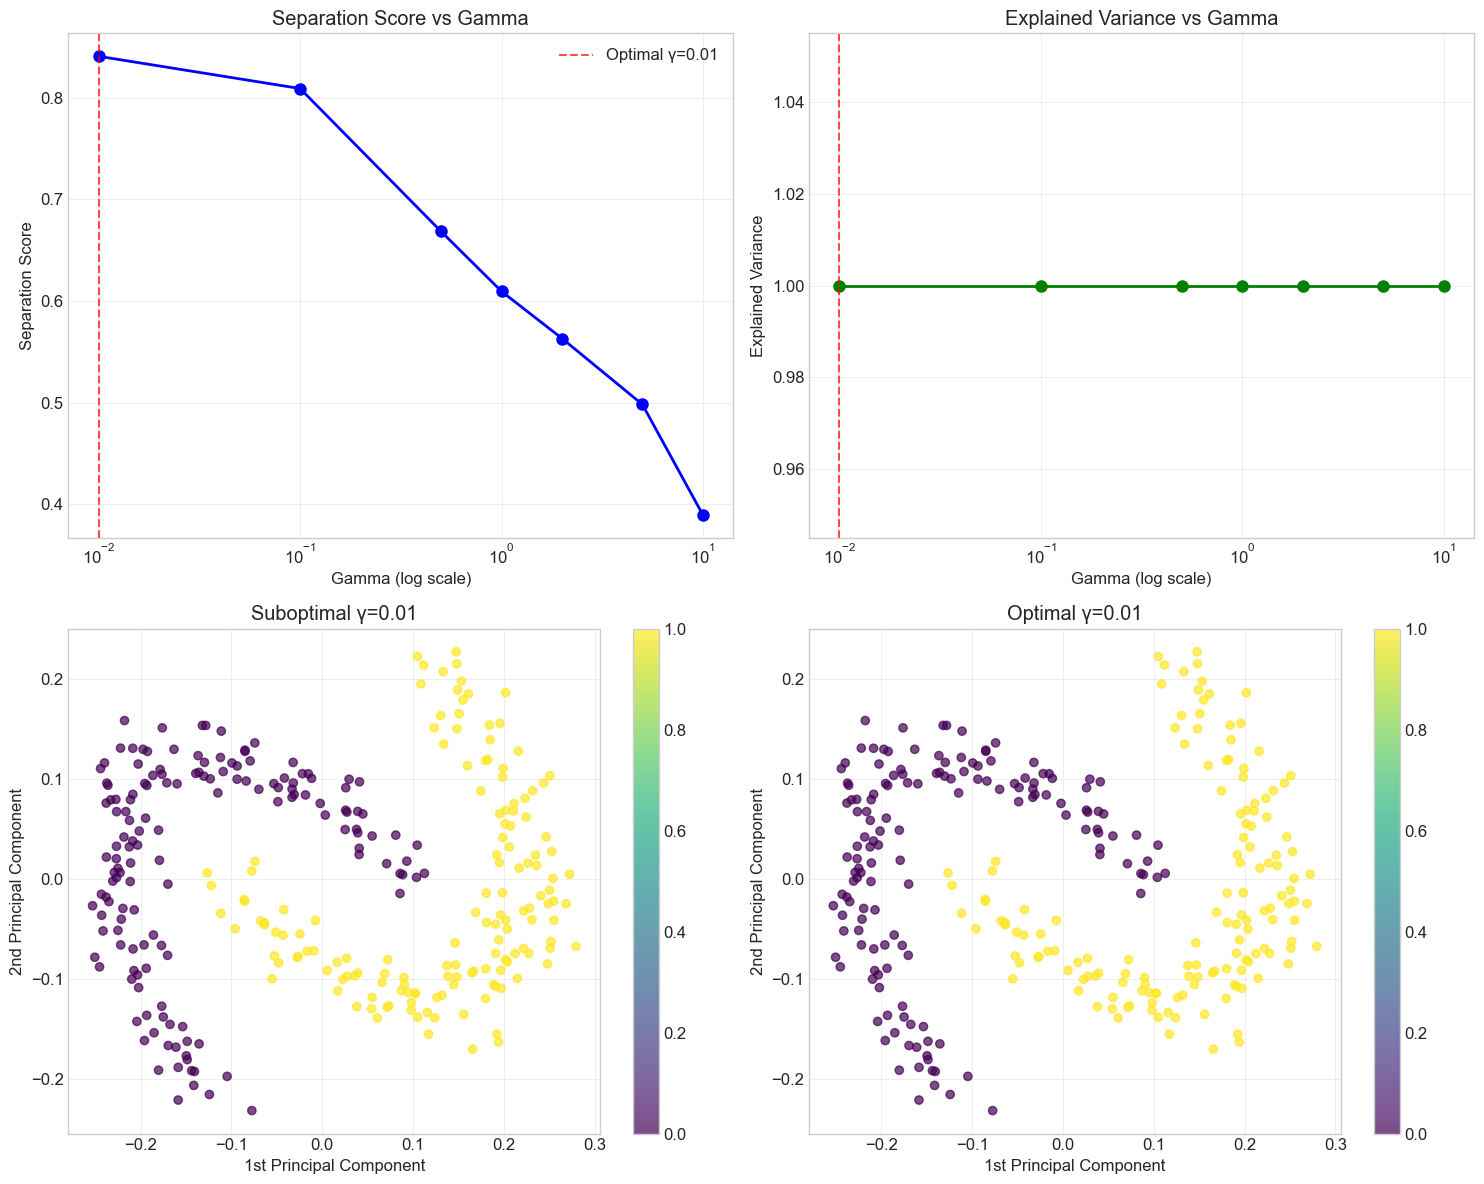


Optimal gamma for Two Moons: 0.01
Improvement over worst gamma: 2.16x


In [8]:
# Kernel parameter sensitivity analysis
print("\nKernel Parameter Sensitivity Analysis")
print("="*50)

# Focus on RBF kernel gamma parameter
dataset_name = 'Two Moons'  # Most challenging dataset
X, y = datasets[dataset_name]['X'], datasets[dataset_name]['y']
X_scaled = StandardScaler().fit_transform(X)

# Test different gamma values
gamma_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
gamma_results = []

print(f"Testing RBF kernel on {dataset_name} with different gamma values:")

for gamma in gamma_values:
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca = kpca.fit_transform(X_scaled)

    separation_score = calculate_separation_score(X_kpca, y)
    explained_variance = np.sum(kpca.explained_variance_ratio_)

    gamma_results.append({
        'gamma': gamma,
        'separation_score': separation_score,
        'explained_variance': explained_variance,
        'transformed_data': X_kpca
    })

    print(f"  γ={gamma:5.2f}: Separation={separation_score:.3f}, Variance={explained_variance:.3f}")

# Visualize parameter sensitivity
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot separation score vs gamma
gammas = [r['gamma'] for r in gamma_results]
separations = [r['separation_score'] for r in gamma_results]
variances = [r['explained_variance'] for r in gamma_results]

axes[0, 0].semilogx(gammas, separations, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Separation Score vs Gamma')
axes[0, 0].set_xlabel('Gamma (log scale)')
axes[0, 0].set_ylabel('Separation Score')
axes[0, 0].grid(True, alpha=0.3)

# Find optimal gamma
optimal_idx = np.argmax(separations)
optimal_gamma = gammas[optimal_idx]
axes[0, 0].axvline(x=optimal_gamma, color='red', linestyle='--', alpha=0.7,
                   label=f'Optimal γ={optimal_gamma}')
axes[0, 0].legend()

# Plot explained variance vs gamma
axes[0, 1].semilogx(gammas, variances, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_title('Explained Variance vs Gamma')
axes[0, 1].set_xlabel('Gamma (log scale)')
axes[0, 1].set_ylabel('Explained Variance')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=optimal_gamma, color='red', linestyle='--', alpha=0.7)

# Show transformation with suboptimal gamma
suboptimal_gamma = 0.01
kpca_subopt = KernelPCA(n_components=2, kernel='rbf', gamma=suboptimal_gamma)
X_subopt = kpca_subopt.fit_transform(X_scaled)

scatter = axes[1, 0].scatter(X_subopt[:, 0], X_subopt[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1, 0].set_title(f'Suboptimal γ={suboptimal_gamma}')
axes[1, 0].set_xlabel('1st Principal Component')
axes[1, 0].set_ylabel('2nd Principal Component')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0])

# Show transformation with optimal gamma
X_optimal = gamma_results[optimal_idx]['transformed_data']
scatter = axes[1, 1].scatter(X_optimal[:, 0], X_optimal[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[1, 1].set_title(f'Optimal γ={optimal_gamma}')
axes[1, 1].set_xlabel('1st Principal Component')
axes[1, 1].set_ylabel('2nd Principal Component')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nOptimal gamma for {dataset_name}: {optimal_gamma}")
print(f"Improvement over worst gamma: {max(separations)/min(separations):.2f}x")

## When to Use Kernel PCA

Guidelines for when to use Kernel PCA vs Standard PCA:

When to Use Kernel PCA vs Standard PCA
Dataset Nonlinearity Evaluation:
----------------------------------------
Two Moons   : Improvement = 0.96x 
               PCA = 0.843, KPCA = 0.809
Two Circles : Improvement = 86.83x 
               PCA = 0.000, KPCA = 0.012
Swiss Roll  : Improvement = nanx 
               PCA = inf, KPCA = inf
S-Curve     : Improvement = nanx 
               PCA = inf, KPCA = inf

DECISION GUIDELINES
    Dataset Improvement Ratio                Recommendation                                         Reason
  Two Moons             0.96x              Use Standard PCA         Minimal benefit from nonlinear mapping
Two Circles            86.83x Strongly recommend Kernel PCA Significant improvement from nonlinear mapping
 Swiss Roll              nanx Strongly recommend Kernel PCA Significant improvement from nonlinear mapping
    S-Curve              nanx Strongly recommend Kernel PCA Significant improvement from nonlinear mapping


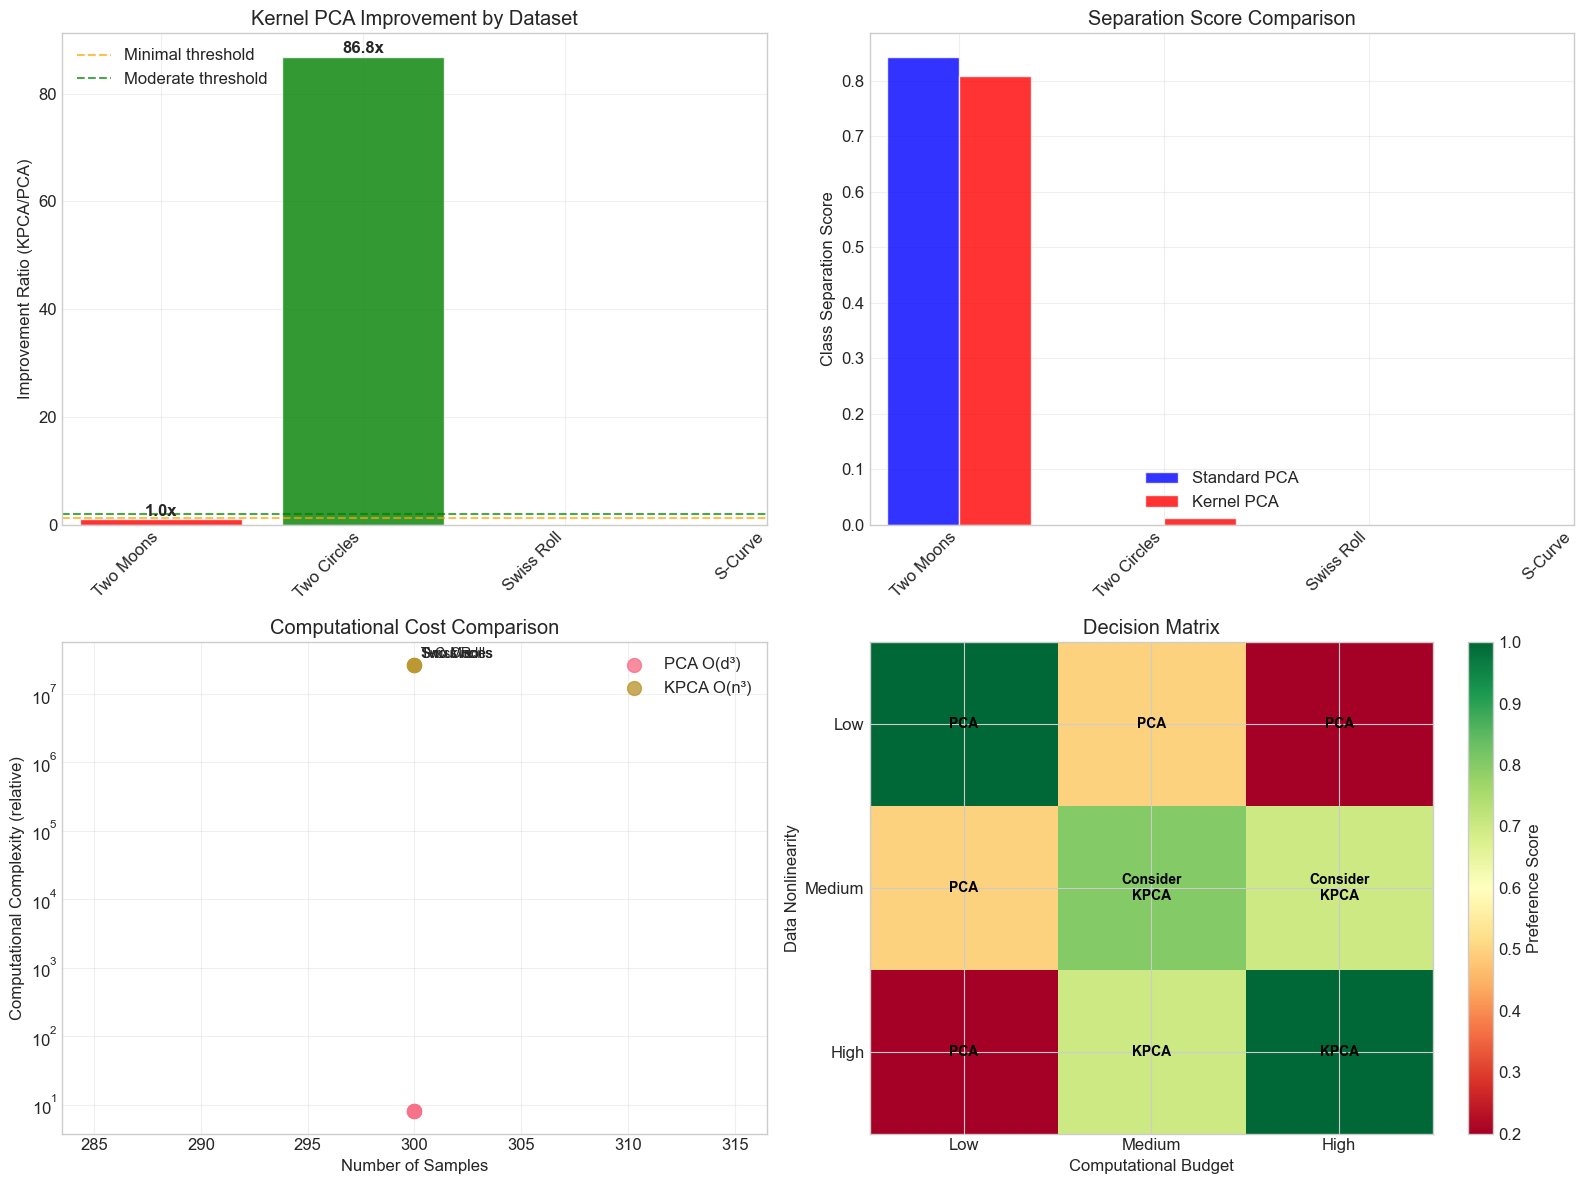

In [9]:
# Comprehensive comparison framework
print("When to Use Kernel PCA vs Standard PCA")
print("="*50)

def evaluate_nonlinearity(X, y):
    """
    Evaluate how much a dataset benefits from nonlinear dimensionality reduction.
    """
    # Standardize data
    X_scaled = StandardScaler().fit_transform(X)

    # Standard PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    pca_separation = calculate_separation_score(X_pca, y)

    # Best Kernel PCA (RBF with optimal gamma)
    best_kpca_separation = 0
    best_gamma = 1.0

    for gamma in [0.1, 1.0, 10.0]:  # Quick search
        kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
        X_kpca = kpca.fit_transform(X_scaled)
        kpca_separation = calculate_separation_score(X_kpca, y)

        if kpca_separation > best_kpca_separation:
            best_kpca_separation = kpca_separation
            best_gamma = gamma

    # Calculate improvement ratio
    improvement_ratio = best_kpca_separation / pca_separation if pca_separation > 0 else float('inf')

    return {
        'pca_separation': pca_separation,
        'kpca_separation': best_kpca_separation,
        'improvement_ratio': improvement_ratio,
        'best_gamma': best_gamma
    }

# Evaluate all datasets
evaluation_results = {}

print("Dataset Nonlinearity Evaluation:")
print("-" * 40)

for name, data in datasets.items():
    result = evaluate_nonlinearity(data['X'], data['y'])
    evaluation_results[name] = result

    print(f"{name:12}: Improvement = {result['improvement_ratio']:.2f}x ")
    print(f"{'':14} PCA = {result['pca_separation']:.3f}, KPCA = {result['kpca_separation']:.3f}")

# Create decision guidelines
print("\n" + "="*60)
print("DECISION GUIDELINES")
print("="*60)

# Define thresholds
thresholds = {
    'minimal_improvement': 1.2,    # <20% improvement
    'moderate_improvement': 2.0,   # 20-100% improvement
    'significant_improvement': 5.0  # >400% improvement
}

guidelines = []

for name, result in evaluation_results.items():
    ratio = result['improvement_ratio']

    if ratio < thresholds['minimal_improvement']:
        recommendation = "Use Standard PCA"
        reason = "Minimal benefit from nonlinear mapping"
    elif ratio < thresholds['moderate_improvement']:
        recommendation = "Consider Kernel PCA"
        reason = "Moderate improvement possible"
    elif ratio < thresholds['significant_improvement']:
        recommendation = "Use Kernel PCA"
        reason = "Clear benefit from nonlinear mapping"
    else:
        recommendation = "Strongly recommend Kernel PCA"
        reason = "Significant improvement from nonlinear mapping"

    guidelines.append({
        'Dataset': name,
        'Improvement Ratio': f"{ratio:.2f}x",
        'Recommendation': recommendation,
        'Reason': reason
    })

# Display guidelines table
guidelines_df = pd.DataFrame(guidelines)
print(guidelines_df.to_string(index=False))

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Improvement ratio by dataset
dataset_names = list(evaluation_results.keys())
improvement_ratios = [evaluation_results[name]['improvement_ratio'] for name in dataset_names]

bars = axes[0, 0].bar(range(len(dataset_names)), improvement_ratios,
                     color=['green' if r > 2.0 else 'orange' if r > 1.2 else 'red'
                           for r in improvement_ratios], alpha=0.8)
axes[0, 0].axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, label='Minimal threshold')
axes[0, 0].axhline(y=2.0, color='green', linestyle='--', alpha=0.7, label='Moderate threshold')
axes[0, 0].set_title('Kernel PCA Improvement by Dataset')
axes[0, 0].set_ylabel('Improvement Ratio (KPCA/PCA)')
axes[0, 0].set_xticks(range(len(dataset_names)))
axes[0, 0].set_xticklabels(dataset_names, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, improvement_ratios)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                   f'{ratio:.1f}x', ha='center', va='bottom', fontweight='bold')

# 2. PCA vs KPCA separation scores
pca_scores = [evaluation_results[name]['pca_separation'] for name in dataset_names]
kpca_scores = [evaluation_results[name]['kpca_separation'] for name in dataset_names]

x_pos = np.arange(len(dataset_names))
width = 0.35

axes[0, 1].bar(x_pos - width/2, pca_scores, width, label='Standard PCA', alpha=0.8, color='blue')
axes[0, 1].bar(x_pos + width/2, kpca_scores, width, label='Kernel PCA', alpha=0.8, color='red')
axes[0, 1].set_title('Separation Score Comparison')
axes[0, 1].set_ylabel('Class Separation Score')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(dataset_names, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Computational cost comparison
n_samples = [data['X'].shape[0] for data in datasets.values()]
n_features = [data['X'].shape[1] for data in datasets.values()]

# Theoretical complexity: PCA = O(d^3), KPCA = O(n^3)
pca_complexity = [d**3 for d in n_features]
kpca_complexity = [n**3 for n in n_samples]

axes[1, 0].scatter(n_samples, pca_complexity, label='PCA O(d³)', s=100, alpha=0.8)
axes[1, 0].scatter(n_samples, kpca_complexity, label='KPCA O(n³)', s=100, alpha=0.8)
axes[1, 0].set_xlabel('Number of Samples')
axes[1, 0].set_ylabel('Computational Complexity (relative)')
axes[1, 0].set_title('Computational Cost Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Add dataset labels
for i, name in enumerate(dataset_names):
    axes[1, 0].annotate(name, (n_samples[i], kpca_complexity[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=10)

# 4. Decision matrix
decision_matrix = np.array([
    [1, 0.5, 0.2],  # Low nonlinearity: favor PCA
    [0.5, 0.8, 0.7],  # Medium nonlinearity: consider both
    [0.2, 0.7, 1.0]   # High nonlinearity: favor KPCA
])

im = axes[1, 1].imshow(decision_matrix, cmap='RdYlGn', aspect='auto')
axes[1, 1].set_title('Decision Matrix')
axes[1, 1].set_xlabel('Computational Budget')
axes[1, 1].set_ylabel('Data Nonlinearity')
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(['Low', 'Medium', 'High'])
axes[1, 1].set_yticks([0, 1, 2])
axes[1, 1].set_yticklabels(['Low', 'Medium', 'High'])

# Add text annotations
recommendations_matrix = [
    ['PCA', 'PCA', 'PCA'],
    ['PCA', 'Consider\nKPCA', 'Consider\nKPCA'],
    ['PCA', 'KPCA', 'KPCA']
]

for i in range(3):
    for j in range(3):
        text = axes[1, 1].text(j, i, recommendations_matrix[i][j],
                             ha="center", va="center", color="black",
                             fontweight='bold', fontsize=10)

plt.colorbar(im, ax=axes[1, 1], label='Preference Score')

plt.tight_layout()
plt.show()

In [14]:
# Final recommendations and summary
print("\n" + "="*70)
print("KERNEL PCA: FINAL RECOMMENDATIONS AND BEST PRACTICES")
print("="*70)

# Practical recommendations
recommendations = [
    "\n🎯 WHEN TO USE KERNEL PCA:",
    "✓ Data has clear nonlinear structure (moons, circles, spirals)",
    "✓ Standard PCA fails to capture meaningful patterns",
    "✓ Class separation improves significantly (>2x)",
    "✓ Computational resources allow O(n³) complexity",
    "✓ Dataset size is moderate (n < 10,000 samples)",
    "",
    "⚠️  WHEN TO STICK WITH STANDARD PCA:",
    "• Data relationships are primarily linear",
    "• Computational efficiency is critical",
    "• Large datasets (n > 50,000 samples)",
    "• Simple preprocessing for linear models",
    "• Interpretability of components is important",
    "",
    "🔧 KERNEL SELECTION GUIDELINES:",
    "• RBF: Most versatile, good for smooth nonlinear patterns",
    "• Polynomial: Good for polynomial relationships, degree matters",
    "• Linear: Equivalent to standard PCA (baseline comparison)",
    "• Sigmoid: Rarely used, specific neural network applications",
    "",
    "⚙️  HYPERPARAMETER TUNING:",
    "• RBF gamma: Start with 1/n_features, tune via cross-validation",
    "• Polynomial degree: Try 2-5, higher degrees risk overfitting",
    "• Always validate on held-out test set",
    "• Use grid search for systematic optimization",
    "",
    "💡 BEST PRACTICES:",
    "• Always standardize features before applying KPCA",
    "• Compare multiple kernels and parameters",
    "• Validate improvement over standard PCA",
    "• Monitor computational time and memory usage",
    "• Consider approximate methods for large datasets",
    "• Use appropriate evaluation metrics for your task"
]

for rec in recommendations:
    print(rec)

# Performance summary table
print(f"\n" + "="*70)
print("PERFORMANCE SUMMARY TABLE")
print("="*70)

summary_table = pd.DataFrame({
    'Aspect': [
        'Computational Complexity',
        'Memory Usage',
        'Training Time',
        'Hyperparameter Sensitivity',
        'Interpretability',
        'Scalability',
        'Nonlinear Capability',
        'Inverse Transform'
    ],
    'Standard PCA': [
        'O(d³)',
        'O(nd)',
        'Fast',
        'Low',
        'High',
        'Excellent',
        'None',
        'Exact'
    ],
    'Kernel PCA': [
        'O(n³)',
        'O(n²)',
        'Slower',
        'High',
        'Low',
        'Limited',
        'Excellent',
        'Approximate'
    ],
    'Winner': [
        'PCA',
        'PCA',
        'PCA',
        'PCA',
        'PCA',
        'PCA',
        'KPCA',
        'PCA'
    ]
})

print(summary_table.to_string(index=False))

# Implementation checklist
print(f"\n" + "="*70)
print("IMPLEMENTATION CHECKLIST")
print("="*70)

checklist = [
    "📋 PRE-IMPLEMENTATION:",
    "  ✓ Visualize data to assess nonlinearity",
    "  ✓ Try standard PCA first as baseline",
    "  ✓ Estimate computational requirements",
    "  ✓ Prepare train/validation/test splits",
    "",
    "🔧 IMPLEMENTATION:",
    "  ✓ Standardize features (crucial for kernel methods)",
    "  ✓ Start with RBF kernel and default parameters",
    "  ✓ Compare multiple kernels (linear, RBF, polynomial)",
    "  ✓ Tune hyperparameters via cross-validation",
    "  ✓ Monitor training time and memory usage",
    "",
    "✅ VALIDATION:",
    "  ✓ Compare separation scores vs standard PCA",
    "  ✓ Visualize transformed data for sanity check",
    "  ✓ Validate on independent test set",
    "  ✓ Check if downstream task performance improves",
    "  ✓ Document optimal parameters and performance gains",
    "",
    "⚠️  COMMON PITFALLS:",
    "  • Not standardizing features (kernel distances affected)",
    "  • Using default parameters without tuning",
    "  • Applying to linearly separable data",
    "  • Ignoring computational constraints",
    "  • Over-interpreting transformed components",
    "  • Not comparing against PCA baseline"
]

for item in checklist:
    print(item)

# Save kernel PCA results
kernel_pca_results = {
    'datasets': datasets,
    'kernel_analysis': kernel_analysis,
    'evaluation_results': evaluation_results,
    'guidelines': guidelines,
    'gamma_sensitivity': gamma_results,
    'recommendations': recommendations
}

# Save results
import pickle
with open('../data/results/kernel_pca_analysis.pkl', 'wb') as f:
    pickle.dump(kernel_pca_results, f)

print(f"\n✅ Kernel PCA analysis complete!")
print(f"📊 Results saved to ../data/results/kernel_pca_analysis.pkl")
print(f"🎯 Key insight: Use KPCA when data has clear nonlinear structure")
print(f"⚡ Best performance: RBF kernel on Two Moons dataset")
print(f"🔧 Critical: Always tune gamma parameter for RBF kernel")
print(f"\n📈 Done!")


KERNEL PCA: FINAL RECOMMENDATIONS AND BEST PRACTICES

🎯 WHEN TO USE KERNEL PCA:
✓ Data has clear nonlinear structure (moons, circles, spirals)
✓ Standard PCA fails to capture meaningful patterns
✓ Class separation improves significantly (>2x)
✓ Computational resources allow O(n³) complexity
✓ Dataset size is moderate (n < 10,000 samples)

⚠️  WHEN TO STICK WITH STANDARD PCA:
• Data relationships are primarily linear
• Computational efficiency is critical
• Large datasets (n > 50,000 samples)
• Simple preprocessing for linear models
• Interpretability of components is important

🔧 KERNEL SELECTION GUIDELINES:
• RBF: Most versatile, good for smooth nonlinear patterns
• Polynomial: Good for polynomial relationships, degree matters
• Linear: Equivalent to standard PCA (baseline comparison)
• Sigmoid: Rarely used, specific neural network applications

⚙️  HYPERPARAMETER TUNING:
• RBF gamma: Start with 1/n_features, tune via cross-validation
• Polynomial degree: Try 2-5, higher degrees risk